In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

import time

# **Data Prepocessing**

In [4]:

df2018 = pd.read_csv('./2018Floor5.csv')
df2019 = pd.read_csv('./2019Floor5.csv')
df = pd.concat([df2018, df2019], ignore_index=True)

# Transformasi data
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
energy = df[['Date', 'z1_AC4(kW)']].copy() 
energy.rename(columns={'z1_AC4(kW)': 'y'}, inplace=True)

energy.set_index('Date', inplace=True)

energy = energy.resample('d').sum() * (1/60)
timestamp = energy.index
energy = energy.reset_index()

In [142]:
energy

Date           y
0   2018-07-01    0.000000
1   2018-07-02  226.172167
2   2018-07-03  211.154500
3   2018-07-04  200.101000
4   2018-07-05  195.875167
..         ...         ...
544 2019-12-27  141.029000
545 2019-12-28    0.000000
546 2019-12-29    0.000000
547 2019-12-30    0.000000
548 2019-12-31    0.000000

[549 rows x 2 columns]

In [6]:
energy['y'].describe()

count    549.000000
mean     119.353520
std       94.534796
min        0.000000
25%        0.000000
50%      159.911500
75%      195.159000
max      260.262333
Name: y, dtype: float64

In [21]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    549 non-null    datetime64[ns]
 1   y       549 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.7 KB


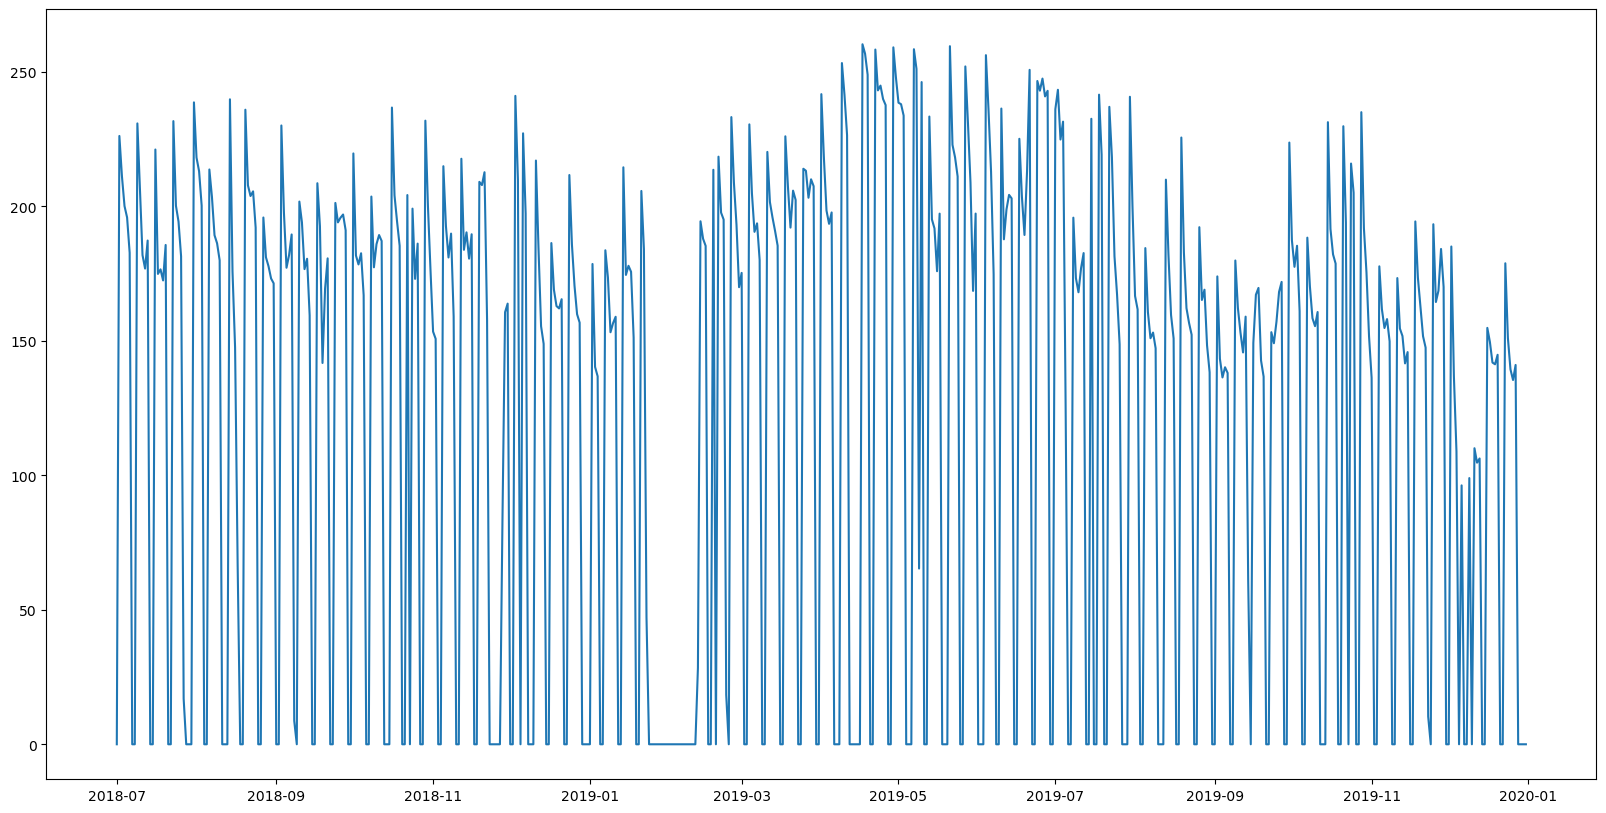

In [14]:
plt.figure(figsize=(20, 10))  # atur ukuran width=12, height=6 (satuan: inci)
plt.plot(energy.index, energy['y'])
plt.show()

# **Pembuatan Fitur Lag**

In [7]:
#untuk model xgboost, rf, svr
energy_lag = energy.copy()
for i in range(1, 8):
    energy_lag[f'lag_{i}'] = energy_lag['y'].shift(i)
energy_lag = energy_lag.dropna().reset_index(drop=True)
X_2d = energy_lag.drop(columns=['Date','y'])
y_2d = energy_lag['y'] 

In [8]:
#untuk model lstm
energy_window = energy.copy()
energy_window = energy_window.drop(columns=['Date'])

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps, :]) 
        y.append(data[i+timesteps, 0]) 
    return np.array(X), np.array(y)

X_3d, y_3d = create_sequences(energy_window.values, 7)

# **Data Split**

In [9]:
def split_dataset(X, y, train_ratio=0.8):
    train_size = int(train_ratio * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, y_train, X_test, y_test

In [10]:
#untuk model xgboost, rf, svr
X_train_2d, y_train_2d, X_test_2d, y_test_2d = split_dataset(X_2d, y_2d)

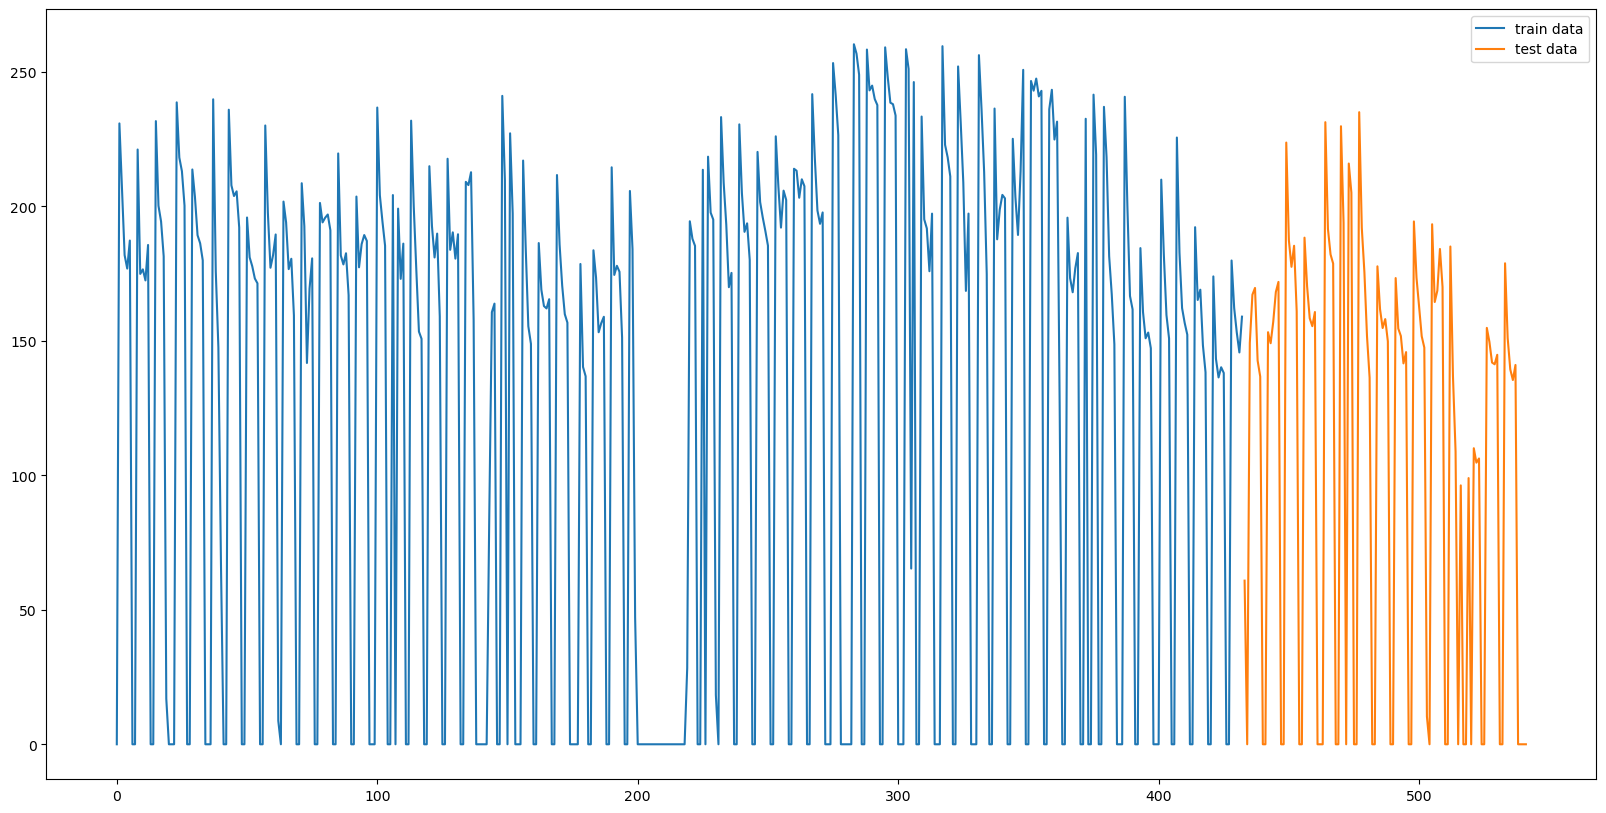

In [11]:
plt.figure(figsize=(20, 10))
y_train_2d.plot(label="train data")
y_test_2d.plot(label="test data")
plt.legend()

In [12]:
#untuk model lstm
X_train_3d, y_train_3d, X_test_3d, y_test_3d = split_dataset(X_3d, y_3d)

In [13]:
#untuk arima
train_size = int(len(energy) * 0.8)
train_data, test_data = energy.iloc[:train_size], energy.iloc[train_size:]

train_arima = train_data['y']
test_arima = test_data['y']

# **Normalisasi Data**

In [14]:
#untuk model xgb, rf, svr
def norm_2d(X_train, y_train, X_test, y_test):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    
    y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
    
    return X_train, y_train, X_test, y_test, scaler_y

X_train_2ds, y_train_2ds, X_test_2ds, y_test_2ds, scaler_y = norm_2d(X_train_2d, y_train_2d, X_test_2d, y_test_2d)

In [15]:
#untuk model lstm
def norm_3d(X_train, y_train, X_test, y_test):
    scaler_X = {}
    scaler_y = MinMaxScaler()

    # Scaling fitur per channel
    for feature_idx in range(X_train.shape[2]):
        scaler_X[feature_idx] = MinMaxScaler()

        train_feat = X_train[:, :, feature_idx].reshape(-1, 1)
        test_feat = X_test[:, :, feature_idx].reshape(-1, 1)

        X_train[:, :, feature_idx] = scaler_X[feature_idx].fit_transform(train_feat).reshape(X_train.shape[0], X_train.shape[1])
        X_test[:, :, feature_idx] = scaler_X[feature_idx].transform(test_feat).reshape(X_test.shape[0], X_test.shape[1])

    # Scaling target
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    return X_train, y_train, X_test, y_test, scaler_y

X_train_3ds, y_train_3ds, X_test_3ds, y_test_3ds, scaler_y = norm_3d(X_train_3d, y_train_3d, X_test_3d, y_test_3d)

# **Pelatihan dan Pengujian**

In [16]:
def apply_regressor(regressor, X_train, y_train, X_test, y_test, scaler):
    regressor.fit(X_train, y_train)

    y_actual, y_pred, score = forecast(regressor, X_train, y_train, X_test, y_test, scaler)

    return y_actual, y_pred, score

def forecast(regressor, X_train, y_train, X_test, y_test, scaler):
    pred_train = regressor.predict(X_train)
    pred_test = regressor.predict(X_test)

    y_train_inv, pred_train_inv = inverse(y_train, pred_train, scaler)
    y_test_inv, pred_test_inv = inverse(y_test, pred_test, scaler)

    train_score = evaluate(y_train_inv, pred_train_inv)
    test_score = evaluate(y_test_inv, pred_test_inv)

    return [y_train_inv, y_test_inv], [pred_train_inv, pred_test_inv], [train_score, test_score]
    
def inverse(y_actual, y_pred, scaler):
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_actual_inv = scaler.inverse_transform(y_actual.reshape(-1, 1)).flatten()
    return y_actual_inv, y_pred_inv

def evaluate(y_actual, y_pred):
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    r2s = r2_score(y_actual, y_pred)
    return [mae, mse, r2s]

## **XGB**

In [26]:
xgb_actual, xgb_pred, xgb_score = apply_regressor(xgb.XGBRegressor(), X_train_2ds, y_train_2ds, X_test_2ds, y_test_2ds, scaler_y)
print(f"Train Score - MAE: {xgb_score[0][0]:.4f}, MSE: {xgb_score[0][1]:.4f}, R2S: {xgb_score[0][2]:.4f}")
print(f"Test Score - MAE: {xgb_score[1][0]:.4f}, MSE: {xgb_score[1][1]:.4f}, R2S: {xgb_score[1][2]:.4f}")

Train Score - MAE: 0.5758, MSE: 2.1593, R2S: 0.9998
Test Score - MAE: 27.9903, MSE: 2353.9850, R2S: 0.6362


## **RF**

In [27]:
rf_actual, rf_pred, rf_score = apply_regressor(RandomForestRegressor(random_state=12), X_train_2ds, y_train_2ds, X_test_2ds, y_test_2ds, scaler_y)
print(f"Train Score - MAE: {rf_score[0][0]:.4f}, MSE: {rf_score[0][1]:.4f}, R2S: {rf_score[0][2]:.4f}")
print(f"Test Score - MAE: {rf_score[1][0]:.4f}, MSE: {rf_score[1][1]:.4f}, R2S: {rf_score[1][2]:.4f}")

Train Score - MAE: 14.0521, MSE: 605.2510, R2S: 0.9362
Test Score - MAE: 24.7110, MSE: 2114.1926, R2S: 0.6733


## **SVR**

In [28]:
svr_actual, svr_pred, svr_score = apply_regressor(SVR(), X_train_2ds, y_train_2ds, X_test_2ds, y_test_2ds, scaler_y)
print(f"Train Score - MAE: {svr_score[0][0]:.4f}, MSE: {svr_score[0][1]:.4f}, R2S: {svr_score[0][2]:.4f}")
print(f"Test Score - MAE: {svr_score[1][0]:.4f}, MSE: {svr_score[1][1]:.4f}, R2S: {svr_score[1][2]:.4f}")

Train Score - MAE: 30.6781, MSE: 2855.0801, R2S: 0.6990
Test Score - MAE: 27.2036, MSE: 2403.3479, R2S: 0.6286


## **LSTM**

In [17]:
model_lstm = Sequential([
    InputLayer((7, 1)),
    LSTM(64),
    Dense(1)
])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model_lstm.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

model_lstm.fit(X_train_3ds, y_train_3ds, epochs=100, batch_size=16)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0590 - mse: 0.0590
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - mse: 0.0545
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - mse: 0.0460
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467 - mse: 0.0467
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0613 - mse: 0.0613
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454 - mse: 0.0454
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 - mse: 0.0485
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - mse: 0.0534
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0519 - mse: 0.0519
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - mse: 0.0508
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0616 - mse: 0.0616
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0521 - mse: 0.0521
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━

In [29]:
model_lstm = tf.keras.models.load_model('./lstm_model_new/lstm_baseline_2.keras')
lstm_actual, lstm_pred, lstm_score = forecast(model_lstm, X_train_3ds, y_train_3ds, X_test_3ds, y_test_3ds, scaler_y)
print(f"Train Score - MAE: {lstm_score[0][0]:.4f}, MSE: {lstm_score[0][1]:.4f}, R2S: {lstm_score[0][2]:.4f}")
print(f"Test Score - MAE: {lstm_score[1][0]:.4f}, MSE: {lstm_score[1][1]:.4f}, R2S: {lstm_score[1][2]:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Score - MAE: 31.6235, MSE: 2481.5929, R2S: 0.7383
Test Score - MAE: 29.8621, MSE: 2544.0019, R2S: 0.6069


In [39]:
model_lstm.save('./lstm_model_new/lstm_baseline_2.keras')

## **ARIMA**

In [18]:
# Uji stasioneritas dengan ADF test
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Test for {title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values: {result[4]}')
    if result[1] < 0.05:
        print('Series is stationary (reject null hypothesis)\n')
    else:
        print('Series is non-stationary (fail to reject null hypothesis)\n')

# Analisis ACF dan PACF
def analyze_acf_pacf(series, lags=100):
    plt.figure(figsize=(12, 8))
    
    # Plot ACF
    plt.subplot(2, 1, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    
    # Plot PACF
    plt.subplot(2, 1, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')



dataset ori
ADF Test for Original Series:
ADF Statistic: -4.0660
p-value: 0.0011
Critical Values: {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}
Series is stationary (reject null hypothesis)

1st differenced
ADF Test for First Differenced Series:
ADF Statistic: -7.9934
p-value: 0.0000
Critical Values: {'1%': -3.4427957890025533, '5%': -2.867029512430173, '10%': -2.5696937122646926}
Series is stationary (reject null hypothesis)

2nd differenced
ADF Test for Second Differenced Series:
ADF Statistic: -9.1287
p-value: 0.0000
Critical Values: {'1%': -3.442819521824351, '5%': -2.8670399588708047, '10%': -2.5696992792614384}
Series is stationary (reject null hypothesis)

acf pcf plot


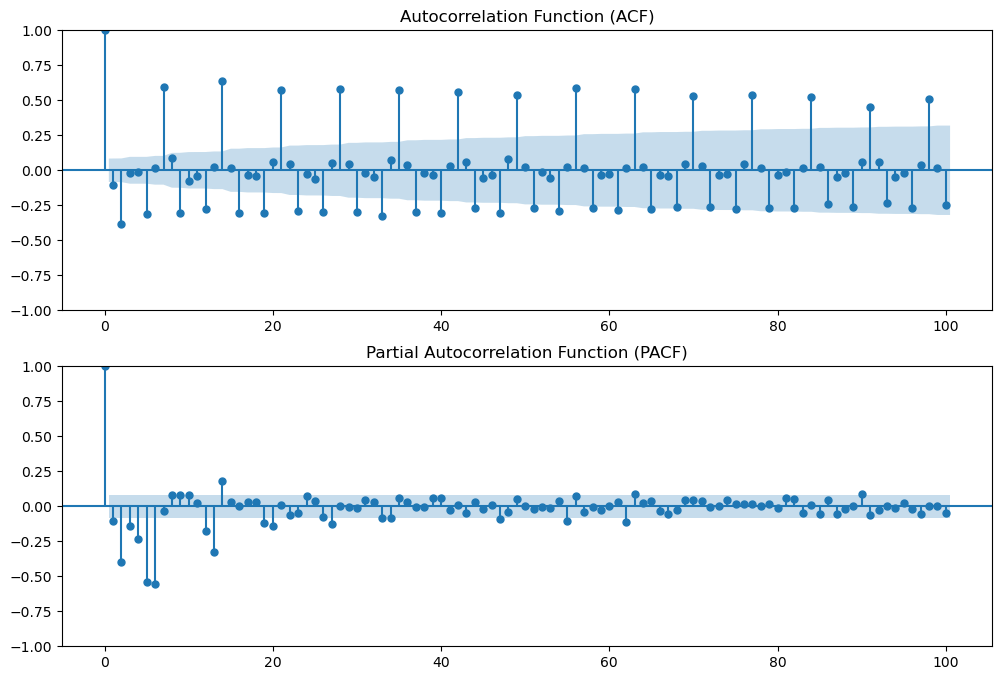

In [19]:
print("dataset ori")
adf_test(energy['y'], 'Original Series')
    
diff1 = energy['y'].diff().dropna()
print("1st differenced")
adf_test(diff1, 'First Differenced Series')
    
diff2 = diff1.diff().dropna()
print("2nd differenced")
adf_test(diff2, 'Second Differenced Series')
    
print("acf pcf plot")
stationary_series = diff1 if adfuller(diff1)[1] < 0.05 else diff2
analyze_acf_pacf(stationary_series)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = list(train_arima)
predictions = []

for t in range(len(test_arima)):
    model = ARIMA(history,
                    order=(7, 0, 8))
    
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)

    obs = test_arima.iloc[t]
    history.append(obs)

    print(f"Step {t+1}/{len(test_arima)} - Actual: {obs:.2f}, Predicted: {yhat:.2f}")


In [31]:
arima_model = pd.read_csv('./arima_new/arima_708')

In [32]:
test_arima

439    158.994500
440     60.840667
441      0.000000
442    149.208833
443    167.150000
          ...    
544    141.029000
545      0.000000
546      0.000000
547      0.000000
548      0.000000
Name: y, Length: 110, dtype: float64

In [33]:
#708
arima_score = evaluate(arima_model['actual'], arima_model['pred'])
print(f"MAE: {arima_score[0]:.4f}, MSE: {arima_score[1]:.4f}, R2S: {arima_score[2]:.4f}")

MAE: 27.5154, MSE: 2024.1518, R2S: 0.6855


# **Peningkatan Akurasi**

## **Penambahan Fitur Berbasis Waktu**

In [53]:
#untuk xgboost, rf, svr
#energy_lag_final merupakan data yang sudah diberi lag dari proses sebelumnya
energy_lag_tb = energy_lag.copy()
df['Date'] = pd.to_datetime(df['Date'])
energy_lag_tb['day_of_week'] = energy_lag_tb['Date'].dt.dayofweek
energy_lag_tb['month'] = energy_lag_tb['Date'].dt.month
energy_lag_tb['is_weekend'] = energy_lag_tb['day_of_week'].isin([5, 6]).astype(int)

X_2d_tb = energy_lag_tb.drop(columns=['Date','y'])
y_2d_tb = energy_lag_tb['y'] 

In [54]:
#untuk lstm
energy_tb = energy.copy()
df['Date'] = pd.to_datetime(df['Date'])
energy_tb['day_of_week'] = energy_tb['Date'].dt.dayofweek
energy_tb['month'] = energy_tb['Date'].dt.month
energy_tb['is_weekend'] = energy_tb['day_of_week'].isin([5, 6]).astype(int)
energy_tb = energy_tb.drop(columns=['Date'])

X_3d_tb, y_3d_tb = create_sequences(energy_tb.values, 7)

In [55]:
#data split
#untuk model xgboost, rf, svr
X_train_2d_tb, y_train_2d_tb, X_test_2d_tb, y_test_2d_tb = split_dataset(X_2d_tb, y_2d_tb)

#untuk model lstm
X_train_3d_tb, y_train_3d_tb, X_test_3d_tb, y_test_3d_tb = split_dataset(X_3d_tb, y_3d_tb)

In [56]:
#normalisasi data
#untuk model xgboost, rf, svr
X_train_2ds_tb, y_train_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y = norm_2d(X_train_2d_tb, y_train_2d_tb, X_test_2d_tb, y_test_2d_tb)

#untuk model lstm
X_train_3ds_tb, y_train_3ds_tb, X_test_3ds_tb, y_test_3ds_tb, scaler_y = norm_3d(X_train_3d_tb, y_train_3d_tb, X_test_3d_tb, y_test_3d_tb)

In [57]:
#pelatihan dan pengujian
#xgb
xgb_actual_tb, xgb_pred_tb, xgb_score_tb = apply_regressor(xgb.XGBRegressor(), X_train_2ds_tb, y_train_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {xgb_score_tb[0][0]:.4f}, MSE: {xgb_score_tb[0][1]:.4f}, R2S: {xgb_score_tb[0][2]:.4f}")
print(f"Test Score - MAE: {xgb_score_tb[1][0]:.4f}, MSE: {xgb_score_tb[1][1]:.4f}, R2S: {xgb_score_tb[1][2]:.4f}")

Train Score - MAE: 0.3867, MSE: 1.1880, R2S: 0.9999
Test Score - MAE: 24.2085, MSE: 1951.2190, R2S: 0.6985


In [58]:
#pelatihan dan pengujian
#rf
rf_actual_tb, rf_pred_tb, rf_score_tb = apply_regressor(RandomForestRegressor(random_state=12), X_train_2ds_tb, y_train_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {rf_score_tb[0][0]:.4f}, MSE: {rf_score_tb[0][1]:.4f}, R2S: {rf_score_tb[0][2]:.4f}")
print(f"Test Score - MAE: {rf_score_tb[1][0]:.4f}, MSE: {rf_score_tb[1][1]:.4f}, R2S: {rf_score_tb[1][2]:.4f}")

Train Score - MAE: 11.3702, MSE: 450.1895, R2S: 0.9525
Test Score - MAE: 21.7671, MSE: 2027.2187, R2S: 0.6867


In [59]:
#pelatihan dan pengujian
#svr
svr_actual_tb, svr_pred_tb, svr_score_tb = apply_regressor(SVR(), X_train_2ds_tb, y_train_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {svr_score_tb[0][0]:.4f}, MSE: {svr_score_tb[0][1]:.4f}, R2S: {svr_score_tb[0][2]:.4f}")
print(f"Test Score - MAE: {svr_score_tb[1][0]:.4f}, MSE: {svr_score_tb[1][1]:.4f}, R2S: {svr_score_tb[1][2]:.4f}")

Train Score - MAE: 26.2342, MSE: 2307.8468, R2S: 0.7567
Test Score - MAE: 24.4892, MSE: 2051.1285, R2S: 0.6830


In [54]:
model_lstm_tb = Sequential([
    InputLayer((7,4)),
    LSTM(64),
    Dense(1)
])

model_lstm_tb.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
model_lstm_tb.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

model_lstm_tb.fit(X_train_3ds_tb, y_train_3ds_tb, epochs=100, batch_size=16)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063 - mse: 0.0063
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mse: 0.0060
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - mse: 0.0072
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mse: 0.0062
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mse: 0.0065
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mse: 0.0035        
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mse: 0.0044
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mse: 0.0060
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mse: 0.0057
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mse: 0.0045
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - mse: 0.0042
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 13/100
28/28 ━━━━━━━━━━

In [60]:
#pelatihan dan pengujian
#lstm
model_lstm_tb = tf.keras.models.load_model('./lstm_model_new/lstm_tb.keras')
lstm_actual_tb, lstm_pred_tb, lstm_score_tb = forecast(model_lstm_tb, X_train_3ds_tb, y_train_3ds_tb, X_test_3ds_tb, y_test_3ds_tb, scaler_y)
print(f"Train Score - MAE: {lstm_score_tb[0][0]:.4f}, MSE: {lstm_score_tb[0][1]:.4f}, R2S: {lstm_score_tb[0][2]:.4f}")
print(f"Test Score - MAE: {lstm_score_tb[1][0]:.4f}, MSE: {lstm_score_tb[1][1]:.4f}, R2S: {lstm_score_tb[1][2]:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Score - MAE: 30.9487, MSE: 2592.0539, R2S: 0.7267
Test Score - MAE: 26.3539, MSE: 2032.4140, R2S: 0.6859


In [ ]:
#sarima
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = list(train_arima)
predictions = []

for t in range(len(test_arima)):
    model = SARIMAX(history,
                    order=(7, 0, 8),
                    seasonal_order=(0, 0, 0, 7),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    trend='c')  # intercept
    
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)

    obs = test_arima.iloc[t]
    history.append(obs)

    print(f"Step {t+1}/{len(test_arima)} - Actual: {obs:.2f}, Predicted: {yhat:.2f}")


In [61]:
sarima_model = pd.read_csv('./arima_new/sarimax_708-000-7')
sarima_score = evaluate(sarima_model['actual'], sarima_model['pred'])
print(f"MAE: {sarima_score[0]:.4f}, MSE: {sarima_score[1]:.4f}, R2S: {sarima_score[2]:.4f}")

MAE: 27.0774, MSE: 2011.5045, R2S: 0.6875


## **Hyperparameter Tuning**

### **XGB**

In [63]:
xgb_params = {
    'learning_rate': [0.3, 0.1, 0.05],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'min_child_weight': [1, 3, 10] 
}

xgb_grid = GridSearchCV(xgb.XGBRegressor(), param_grid=xgb_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error', verbose=3)
xgb_grid.fit(X_train_2ds_tb, y_train_2ds_tb)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.137 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.276 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.273 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.240 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.166 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.5],
                         'learning_rate': [0.3, 0.1, 0.05],
                         'max_depth': [3, 6, 9], 'min_child_weight': [1, 3, 10],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=3)

In [65]:
xgb_grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 10,
 'n_estimators': 100,
 'subsample': 1.0}

In [62]:
xgb_ht = xgb.XGBRegressor(
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=10,
    n_estimators=100,
    subsample=1.0
)

xgb_actual_ht, xgb_pred_ht, xgb_score_ht = apply_regressor(xgb_ht, X_train_2ds_tb, y_train_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {xgb_score_ht[0][0]:.4f}, MSE: {xgb_score_ht[0][1]:.4f}, R2S: {xgb_score_ht[0][2]:.4f}")
print(f"Test Score - MAE: {xgb_score_ht[1][0]:.4f}, MSE: {xgb_score_ht[1][1]:.4f}, R2S: {xgb_score_ht[1][2]:.4f}")

Train Score - MAE: 25.4750, MSE: 1922.9809, R2S: 0.7972
Test Score - MAE: 22.2828, MSE: 1739.0975, R2S: 0.7313


### **RF**

In [156]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error', verbose=3)
rf_grid.fit(X_train_2ds_tb, y_train_2ds_tb)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.107 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.200 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.269 total time=   0.1s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.279 total time=   0.1s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.089 total time=   0.1s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.108 total time=   0.1s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.204 total time=   0.2s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, sc

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 7],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=3)

In [70]:
rf_grid.best_params_

{'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [63]:
rf_ht = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=1
)
rf_actual_ht, rf_pred_ht, rf_score_ht = apply_regressor(rf_ht, X_train_2ds_tb, y_train_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {rf_score_ht[0][0]:.4f}, MSE: {rf_score_ht[0][1]:.4f}, R2S: {rf_score_ht[0][2]:.4f}")
print(f"Test Score - MAE: {rf_score_ht[1][0]:.4f}, MSE: {rf_score_ht[1][1]:.4f}, R2S: {rf_score_ht[1][2]:.4f}")

Train Score - MAE: 20.2216, MSE: 1467.1505, R2S: 0.8453
Test Score - MAE: 20.6055, MSE: 1825.7571, R2S: 0.7179


### **SVR**

In [157]:
svr_params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.001, 0.01, 0.1, 1],
    'gamma': ['scale', 0.01, 0.1, 1],
}
svr_grid = GridSearchCV(SVR(), param_grid=svr_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error', verbose=3)
svr_grid.fit(X_train_2ds_tb, y_train_2ds_tb)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.109 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.232 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.176 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.161 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.131 total time=   0.0s
[CV 1/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.262 total time=   0.0s
[CV 2/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.340 total time=   0.0s
[CV 3/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.276 total time=   0.0s
[CV 4/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.255 total time=   0.0s
[CV 5/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.169 total time=   0.0s
[CV 1/5] END ..C=0.1, epsilon=0.001, gamma=0.1;, score=-0.117 total time=   0.0s
[CV 2/5] END ..C=0.1, epsilon=0.001, gamma=0.1;

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': ['scale', 0.01, 0.1, 1]},
             scoring='neg_mean_absolute_error', verbose=3)

In [152]:
svr_grid.best_params_

{'C': 100, 'epsilon': 0.001, 'gamma': 0.01}

In [64]:
svr_ht = SVR(
    C=100,
    epsilon=0.001,
    gamma=0.01
)
svr_actual_ht, svr_pred_ht, svr_score_ht = apply_regressor(svr_ht,  X_train_2ds_tb, y_train_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {svr_score_ht[0][0]:.4f}, MSE: {svr_score_ht[0][1]:.4f}, R2S: {svr_score_ht[0][2]:.4f}")
print(f"Test Score - MAE: {svr_score_ht[1][0]:.4f}, MSE: {svr_score_ht[1][1]:.4f}, R2S: {svr_score_ht[1][2]:.4f}")

Train Score - MAE: 25.9426, MSE: 2856.8254, R2S: 0.6988
Test Score - MAE: 21.4333, MSE: 1839.9893, R2S: 0.7157


### **LSTM**

In [46]:
def build_lstm(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_train_3ds_tb.shape[1], X_train_3ds_tb.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, activation='linear')) 
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mse'])
    return model

model = KerasRegressor(model=build_lstm, verbose=1)

param_grid = {
    'model__units': [64, 128],                 
    'model__dropout_rate': [0.2, 0.3],        
    'batch_size': [10, 16, 32],                   
    'epochs': [20, 50],                       
    'model__learning_rate': [0.001, 0.005] 
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train_3ds_tb, y_train_3ds_tb)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3370 - mse: 0.3370
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1820 - mse: 0.1820 
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1425 - mse: 0.1425 
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1452 - mse: 0.1452 
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1389 - mse: 0.1389 
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1154 - mse: 0.1154 
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1319 - mse: 0.1319 
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1097 - mse: 0.1097 
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1161 - mse: 0.1161 
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1028 - mse: 0.1028 
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0945 - mse: 0.0945 
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0926 - mse: 0.0926 


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KerasRegressor(model=<function build_lstm at 0x0000013C492C8360>),
             param_grid={'batch_size': [10, 16, 32], 'epochs': [20, 50],
                         'model__dropout_rate': [0.2, 0.3],
                         'model__learning_rate': [0.001, 0.005],
                         'model__units': [64, 128]},
             scoring='neg_mean_squared_error', verbose=1)

In [47]:
grid_search.best_params_

{'batch_size': 10,
 'epochs': 20,
 'model__dropout_rate': 0.3,
 'model__learning_rate': 0.005,
 'model__units': 128}

In [56]:
model_lstm_ht = Sequential([
    InputLayer((7, 4)),
    Dropout(0.3),
    LSTM(128),
    Dense(1)
])

model_lstm_ht.summary()

Model: "sequential_248"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_247 (Dropout)                │ (None, 7, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_248 (LSTM)                      │ (None, 128)                 │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_248 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,225 (266.50 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
model_lstm_ht.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.005), metrics=['mse'])

model_lstm_ht.fit(X_train_3ds_tb, y_train_3ds_tb, epochs=20, batch_size=10)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0290 - mse: 0.0290
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0442 - mse: 0.0442
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0383 - mse: 0.0383
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0411 - mse: 0.0411
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0377 - mse: 0.0377
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0348 - mse: 0.0348
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0407 - mse: 0.0407
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0444 - mse: 0.0444
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0392 - mse: 0.0392
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0350 - mse: 0.0350
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0464 - mse: 0.0464
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0384 - mse: 0.0384
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

In [65]:
model_lstm_ht=tf.keras.models.load_model('./lstm_model_new/lstm_ht_2.keras')
lstm_actual_ht, lstm_pred_ht, lstm_score_ht = forecast(model_lstm_ht, X_train_3ds_tb, y_train_3ds_tb, X_test_3ds_tb, y_test_3ds_tb, scaler_y)
print(f"Train Score - MAE: {lstm_score_ht[0][0]:.4f}, MSE: {lstm_score_ht[0][1]:.4f}, R2S: {lstm_score_ht[0][2]:.4f}")
print(f"Test Score - MAE: {lstm_score_ht[1][0]:.4f}, MSE: {lstm_score_ht[1][1]:.4f}, R2S: {lstm_score_ht[1][2]:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train Score - MAE: 34.5020, MSE: 2580.8604, R2S: 0.7279
Test Score - MAE: 24.7183, MSE: 1844.9718, R2S: 0.7149


In [160]:
model_lstm_ht.save('./lstm_model_new/lstm_ht_2.keras')

### **ARIMA**

In [ ]:
from pmdarima import auto_arima

In [ ]:
arima_ht = auto_arima(train_arima, 
                      start_p=0, 
                      d=0, 
                      start_q=0, 
                      max_p=10, 
                      max_q=10, 
                      start_P=0, 
                      D=0, 
                      start_Q=0, 
                      max_P=10, 
                      max_Q=10, 
                      m=7, 
                      seasonal=True, 
                      trace=True, 
                      supress_warning=True, 
                      stepwise=False, 
                      n_fits=50)

In [ ]:
arima_ht.summary()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = list(train_arima)
predictions = []

for t in range(len(test_arima)):
    model = SARIMAX(history,
                    order=(1, 0, 0),
                    seasonal_order=(1, 0, 1, 7),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    trend='c')  # intercept
    
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)

    obs = test_arima.iloc[t]
    history.append(obs)

    print(f"Step {t+1}/{len(test_arima)} - Actual: {obs:.2f}, Predicted: {yhat:.2f}")


In [66]:
arima_ht = pd.read_csv('./arima_new/sarimax_100-101-7')
arima_score_ht = evaluate(arima_ht['actual'], arima_ht['pred'])
print(f"MAE: {arima_score_ht[0]:.4f}, MSE: {arima_score_ht[1]:.4f}, R2S: {arima_score_ht[2]:.4f}")

MAE: 23.6817, MSE: 1923.1133, R2S: 0.7012


# **Score**

In [164]:
score_baseline = pd.DataFrame({
    'regressor': ['XGB', 'Random Forest', 'SVR', 'LSTM', 'ARIMA'], 
    'MAE': [xgb_score[1][0], rf_score[1][0], svr_score[1][0], lstm_score[1][0], arima_score[0]],
    'MSE': [xgb_score[1][1], rf_score[1][1], svr_score[1][1], lstm_score[1][1], arima_score[1]],
    'R2S': [xgb_score[1][2], rf_score[1][2], svr_score[1][2], lstm_score[1][2], arima_score[2]]
})
score_baseline.round(2)

regressor    MAE      MSE   R2S
0            XGB  27.99  2353.99  0.64
1  Random Forest  24.71  2114.19  0.67
2            SVR  27.20  2403.35  0.63
3           LSTM  29.86  2544.00  0.61
4          ARIMA  27.52  2024.15  0.69

In [163]:
score_tb = pd.DataFrame({
    'regressor': ['XGB', 'Random Forest', 'SVR', 'LSTM', 'ARIMA'], 
    'MAE': [xgb_score_tb[1][0], rf_score_tb[1][0], svr_score_tb[1][0], lstm_score_tb[1][0], sarima_score[0]],
    'MSE': [xgb_score_tb[1][1], rf_score_tb[1][1], svr_score_tb[1][1], lstm_score_tb[1][1], sarima_score[1]],
    'R2S': [xgb_score_tb[1][2], rf_score_tb[1][2], svr_score_tb[1][2], lstm_score_tb[1][2], sarima_score[2]]
})
score_tb.round(2)

regressor    MAE      MSE   R2S
0            XGB  24.21  1951.22  0.70
1  Random Forest  21.77  2027.22  0.69
2            SVR  24.49  2051.13  0.68
3           LSTM  26.35  2032.41  0.69
4          ARIMA  27.08  2011.50  0.69

In [166]:
score_ht = pd.DataFrame({
    'regressor': ['XGB', 'Random Forest', 'SVR', 'LSTM', 'ARIMA'], 
    'MAE': [xgb_score_ht[1][0], rf_score_ht[1][0], svr_score_ht[1][0], lstm_score_ht[1][0], arima_score_ht[0]],
    'MSE': [xgb_score_ht[1][1], rf_score_ht[1][1], svr_score_ht[1][1], lstm_score_ht[1][1], arima_score_ht[1]],
    'R2S': [xgb_score_ht[1][2], rf_score_ht[1][2], svr_score_ht[1][2], lstm_score_ht[1][2], arima_score_ht[2]]
})
score_ht.round(2)

regressor    MAE      MSE   R2S
0            XGB  22.28  1739.10  0.73
1  Random Forest  20.61  1825.76  0.72
2            SVR  21.43  1839.99  0.72
3           LSTM  24.72  1844.97  0.71
4          ARIMA  23.68  1923.11  0.70

# **Plotting**

In [37]:
timestamps_test = energy['Date'].iloc[-len(y_test_3d):].reset_index(drop=True)
timestamps_test

0     2019-09-14
1     2019-09-15
2     2019-09-16
3     2019-09-17
4     2019-09-18
         ...    
104   2019-12-27
105   2019-12-28
106   2019-12-29
107   2019-12-30
108   2019-12-31
Name: Date, Length: 109, dtype: datetime64[ns]

In [167]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_comparison(model,
                    y_actual, 
                    y_pred_lag, 
                    y_pred_lag_time, 
                    y_pred_tuned, 
                    timestamps, 
                    start_date, 
                    end_date):
    
    # Buat DataFrame dasar
    df_plot = pd.DataFrame({
        "timestamp": pd.to_datetime(timestamps),
        "actual": y_actual,
        "pred_lag": y_pred_lag,
        "pred_lag_time": y_pred_lag_time,
        "pred_tuned": y_pred_tuned
    })
    
    df_plot.set_index("timestamp", inplace=True)
    
    # Filter berdasarkan rentang tanggal
    df_filtered = df_plot.loc[start_date:end_date]
    
    # Buat 3 subplot horizontal
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    
    # Subplot 1 - Lag features only
    axs[0].plot(df_filtered.index, df_filtered["actual"], label="Actual", color="orange")
    axs[0].plot(df_filtered.index, df_filtered["pred_lag"], label="Predicted", color="blue")
    axs[0].set_title("Lag Features Only")
    axs[0].set_xlabel("Timestamp")
    axs[0].set_ylabel("Energy Consumption (kWh)")
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].grid(True)
    axs[0].legend()  # Legend di subplot pertama

    # Subplot 2 - Lag + Time features
    axs[1].plot(df_filtered.index, df_filtered["actual"], label="Actual", color="orange")
    axs[1].plot(df_filtered.index, df_filtered["pred_lag_time"], label="Predicted", color="blue")
    axs[1].set_title("Lag + Time Features")
    axs[1].set_xlabel("Timestamp")
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].grid(True)
    axs[1].legend()  # Legend di subplot kedua

    # Subplot 3 - After Hyperparameter Tuning
    axs[2].plot(df_filtered.index, df_filtered["actual"], label="Actual", color="orange")
    axs[2].plot(df_filtered.index, df_filtered["pred_tuned"], label="Predicted", color="blue")
    axs[2].set_title("After Hyperparameter Tuning")
    axs[2].set_xlabel("Timestamp")
    axs[2].tick_params(axis='x', rotation=45)
    axs[2].grid(True)
    axs[2].legend()  # Legend di subplot ketiga

    fig.suptitle(f"{model}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


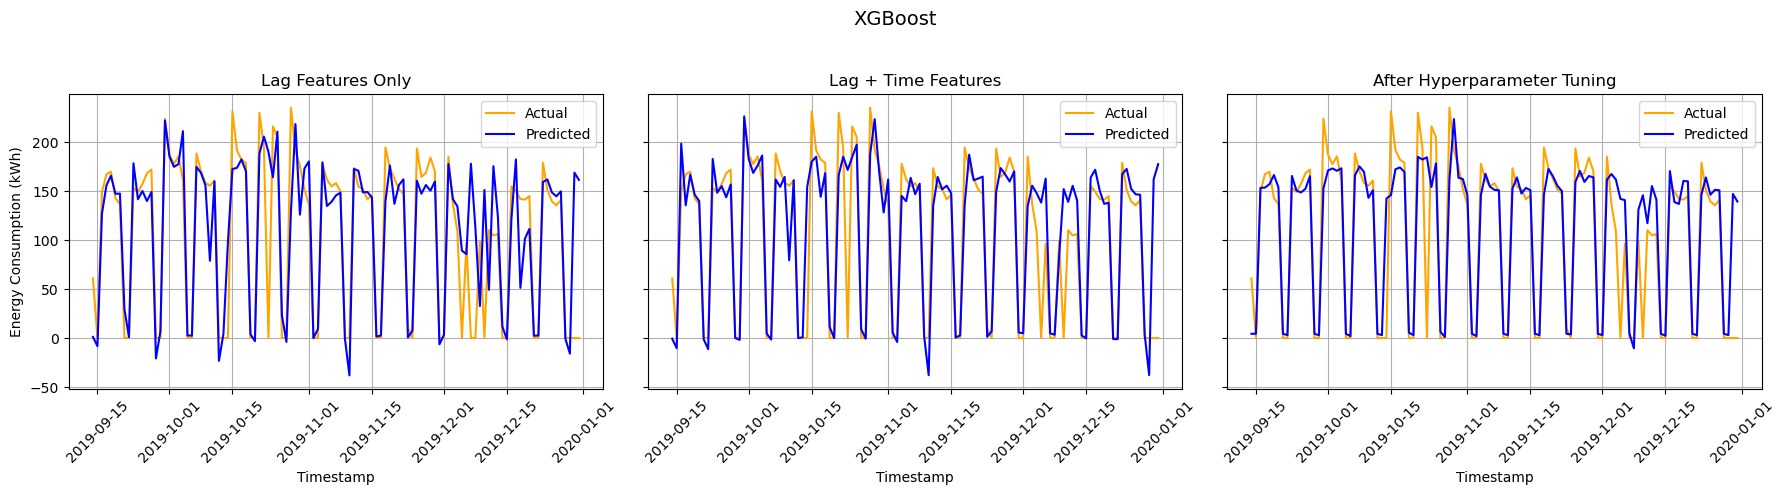

In [168]:
plot_comparison(
    model="XGBoost",
    y_actual=xgb_actual[1],
    y_pred_lag=xgb_pred[1],
    y_pred_lag_time=xgb_pred_tb[1],
    y_pred_tuned=xgb_pred_ht[1],
    timestamps=timestamps_test,
    start_date="2019-01-01",
    end_date="2019-12-31"
)


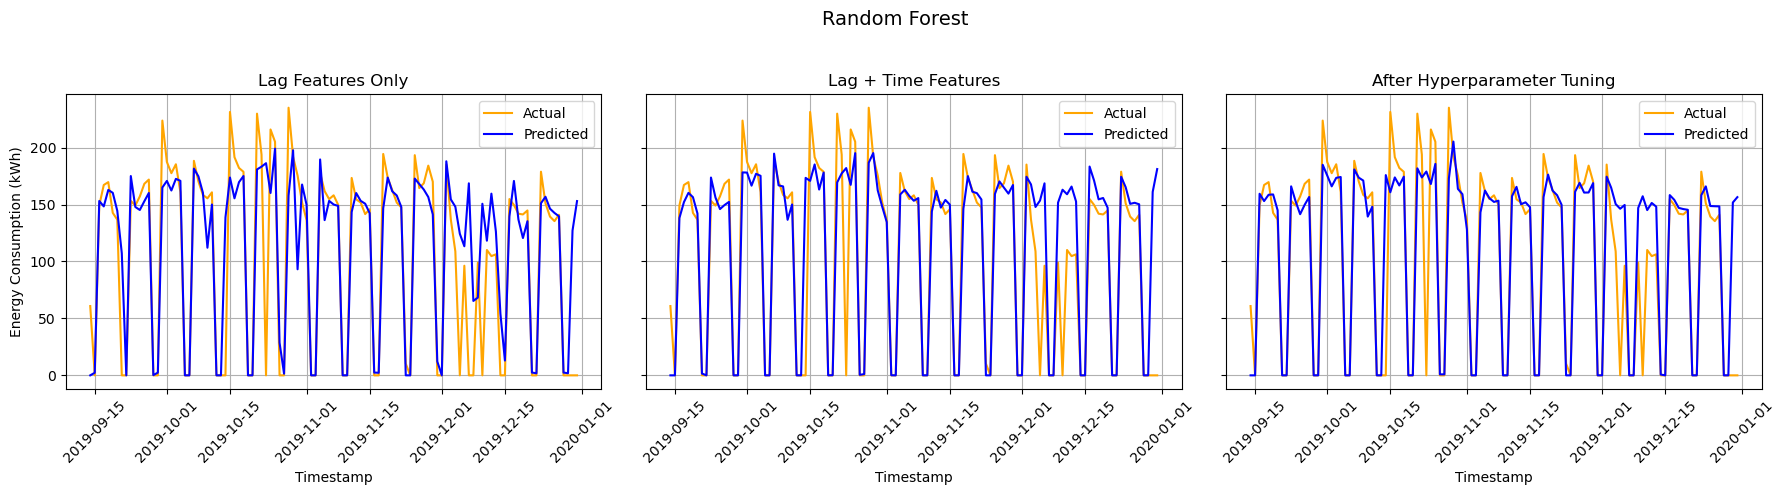

In [169]:
plot_comparison(
    model="Random Forest",
    y_actual=rf_actual[1],
    y_pred_lag=rf_pred[1],
    y_pred_lag_time=rf_pred_tb[1],
    y_pred_tuned=rf_pred_ht[1],
    timestamps=timestamps_test,
    start_date="2019-01-01",
    end_date="2019-12-31"
)


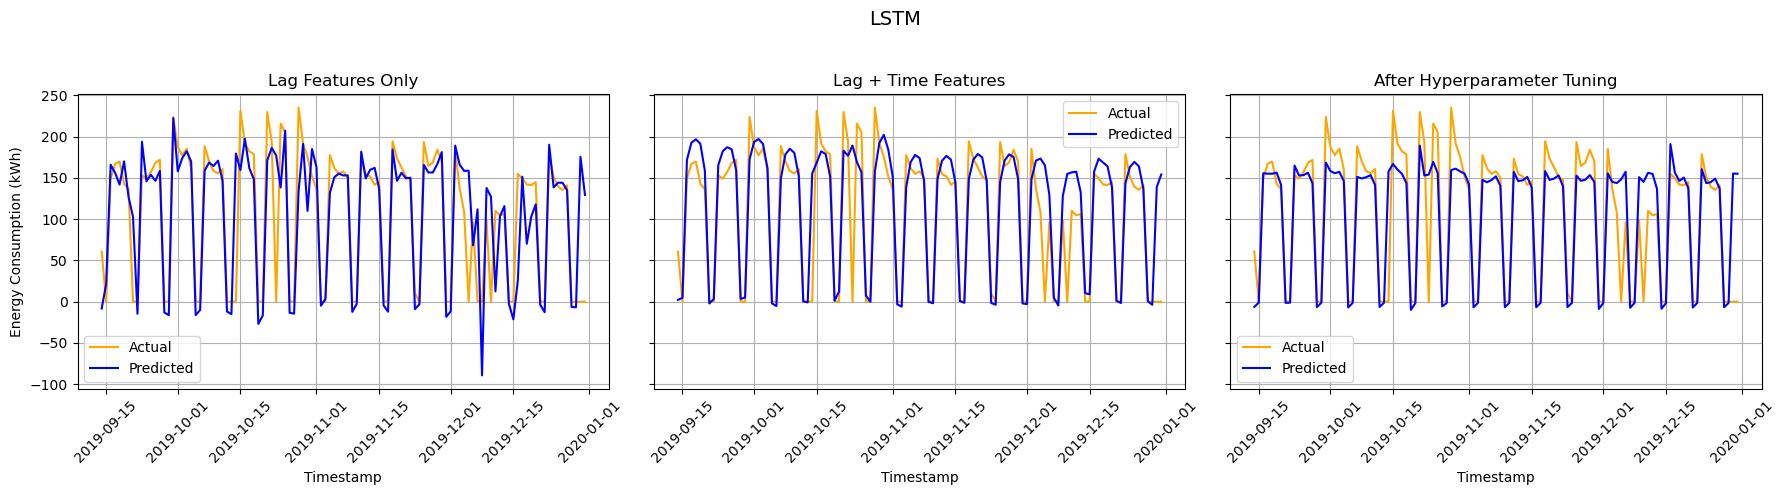

In [170]:
plot_comparison(
    model="LSTM",
    y_actual=lstm_actual[1],
    y_pred_lag=lstm_pred[1],
    y_pred_lag_time=lstm_pred_tb[1],
    y_pred_tuned=lstm_pred_ht[1],
    timestamps=timestamps_test,
    start_date="2019-01-01",
    end_date="2019-12-31"
)


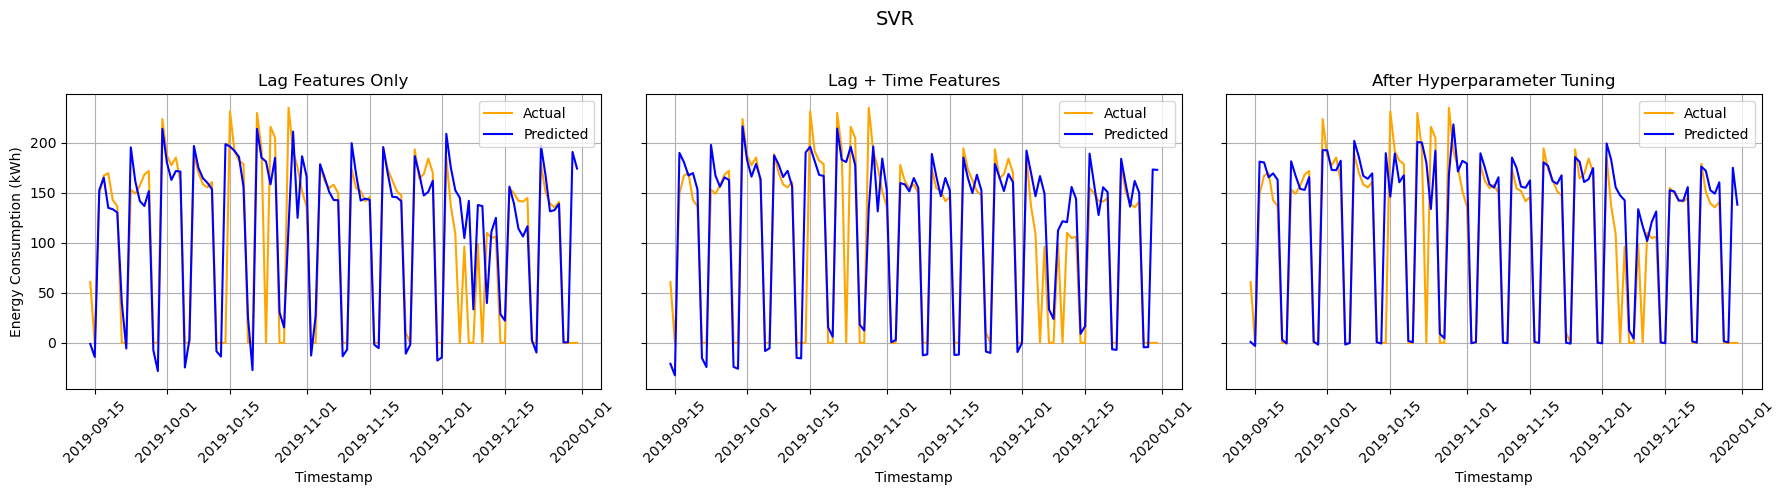

In [171]:
plot_comparison(
    model="SVR",
    y_actual=svr_actual[1],
    y_pred_lag=svr_pred[1],
    y_pred_lag_time=svr_pred_tb[1],
    y_pred_tuned=svr_pred_ht[1],
    timestamps=timestamps_test,
    start_date="2019-01-01",
    end_date="2019-12-31"
)


In [172]:
test_timestamp = timestamp[train_size:]

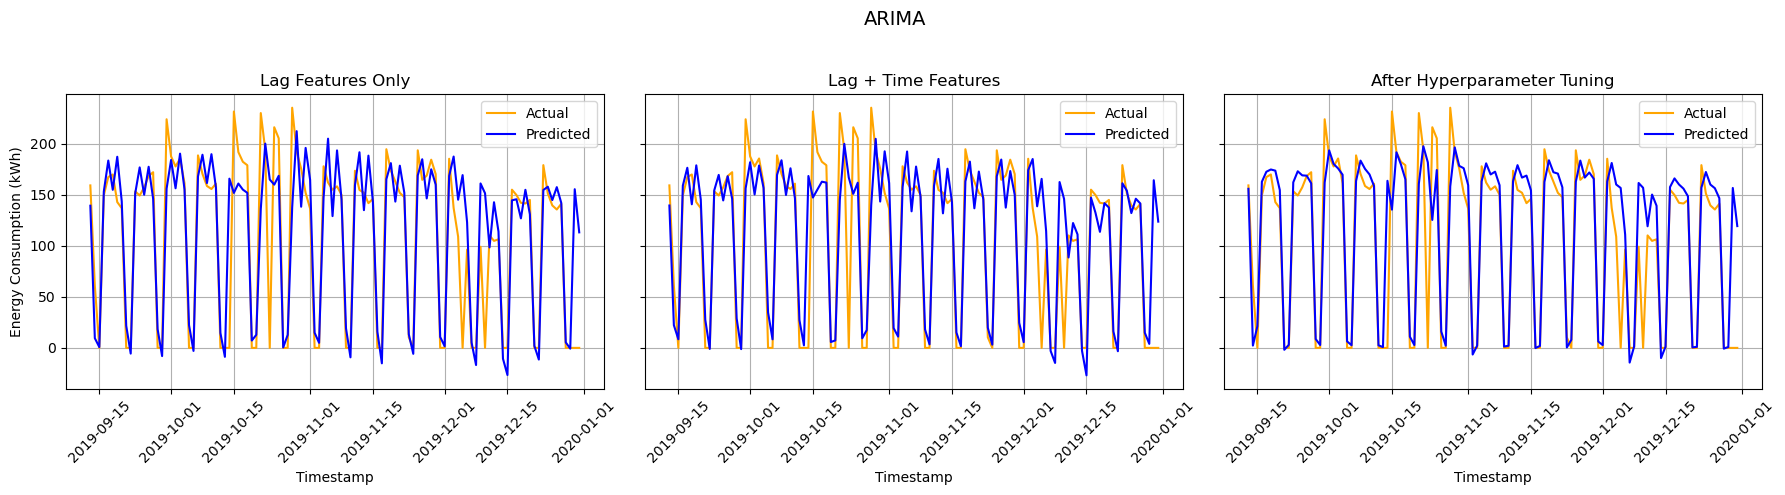

In [173]:
plot_comparison(
    model="ARIMA",
    y_actual=arima_model['actual'],
    y_pred_lag=arima_model['pred'],
    y_pred_lag_time=sarima_model['pred'],
    y_pred_tuned= arima_ht['pred'],
    timestamps=test_timestamp,
    start_date="2019-01-01",
    end_date="2019-12-31"
)

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_comparison_lag_only(models, 
                             y_actual, 
                             y_pred_lags, 
                             timestamps):

    
    df_plot = pd.DataFrame({
        "timestamp": pd.to_datetime(timestamps),
        "actual": y_actual
    })
    
    for i, model in enumerate(models):
        df_plot[f"pred_lag_{model}"] = y_pred_lags[i]
    
    df_plot.set_index("timestamp", inplace=True)
    
    fig = plt.figure(figsize=(18, 10))
    
    ax1 = plt.subplot2grid((2, 3), (0, 0))
    ax2 = plt.subplot2grid((2, 3), (0, 1))
    ax3 = plt.subplot2grid((2, 3), (0, 2))
    ax4 = plt.subplot2grid((2, 3), (1, 0))
    ax5 = plt.subplot2grid((2, 3), (1, 1))
    
    axs = [ax1, ax2, ax3, ax4, ax5]
    
    for i, (model, ax) in enumerate(zip(models, axs)):
        ax.plot(df_plot.index, df_plot["actual"], label="Actual", color="orange")
        ax.plot(df_plot.index, df_plot[f"pred_lag_{model}"], label="Predicted", color="blue")
        ax.set_title(f"{model}")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Energy Consumption (kWh)" if i in [0, 3] else "")  # Label y hanya di kiri
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

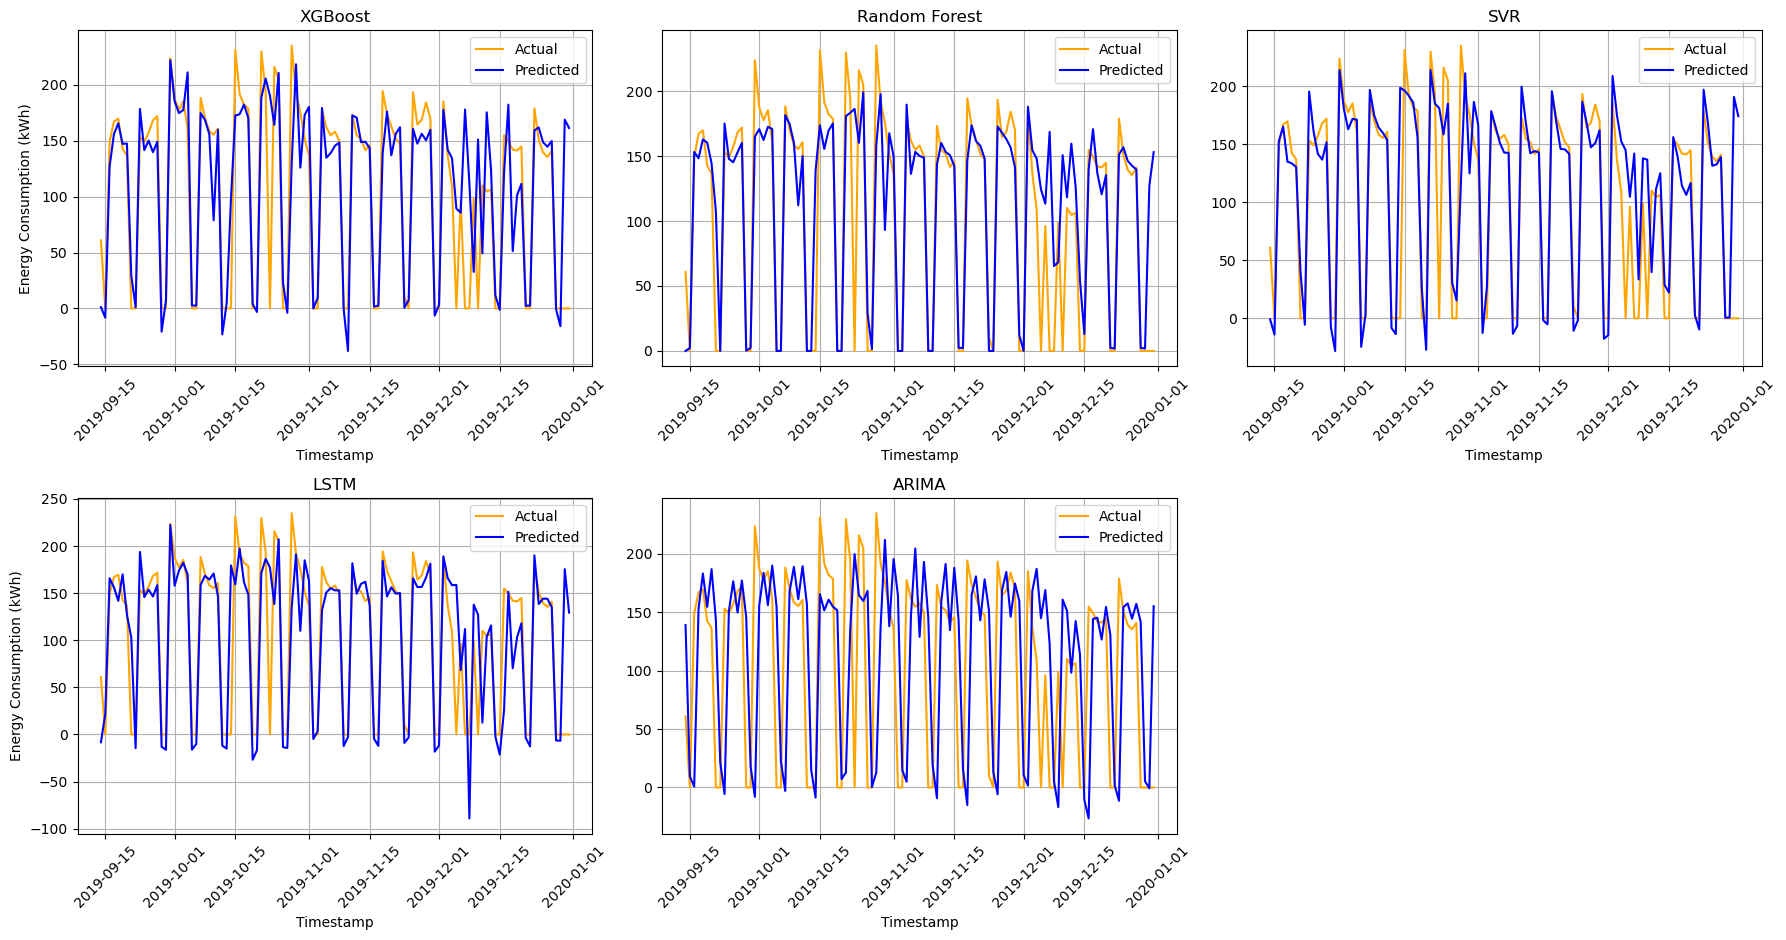

In [50]:
models = ["XGBoost", "Random Forest", "SVR", "LSTM", "ARIMA"]
y_pred_lags = [xgb_pred[1], rf_pred[1], svr_pred[1], lstm_pred[1], arima_model['pred']]
plot_comparison_lag_only(models, svr_actual[1], y_pred_lags, timestamps_test)

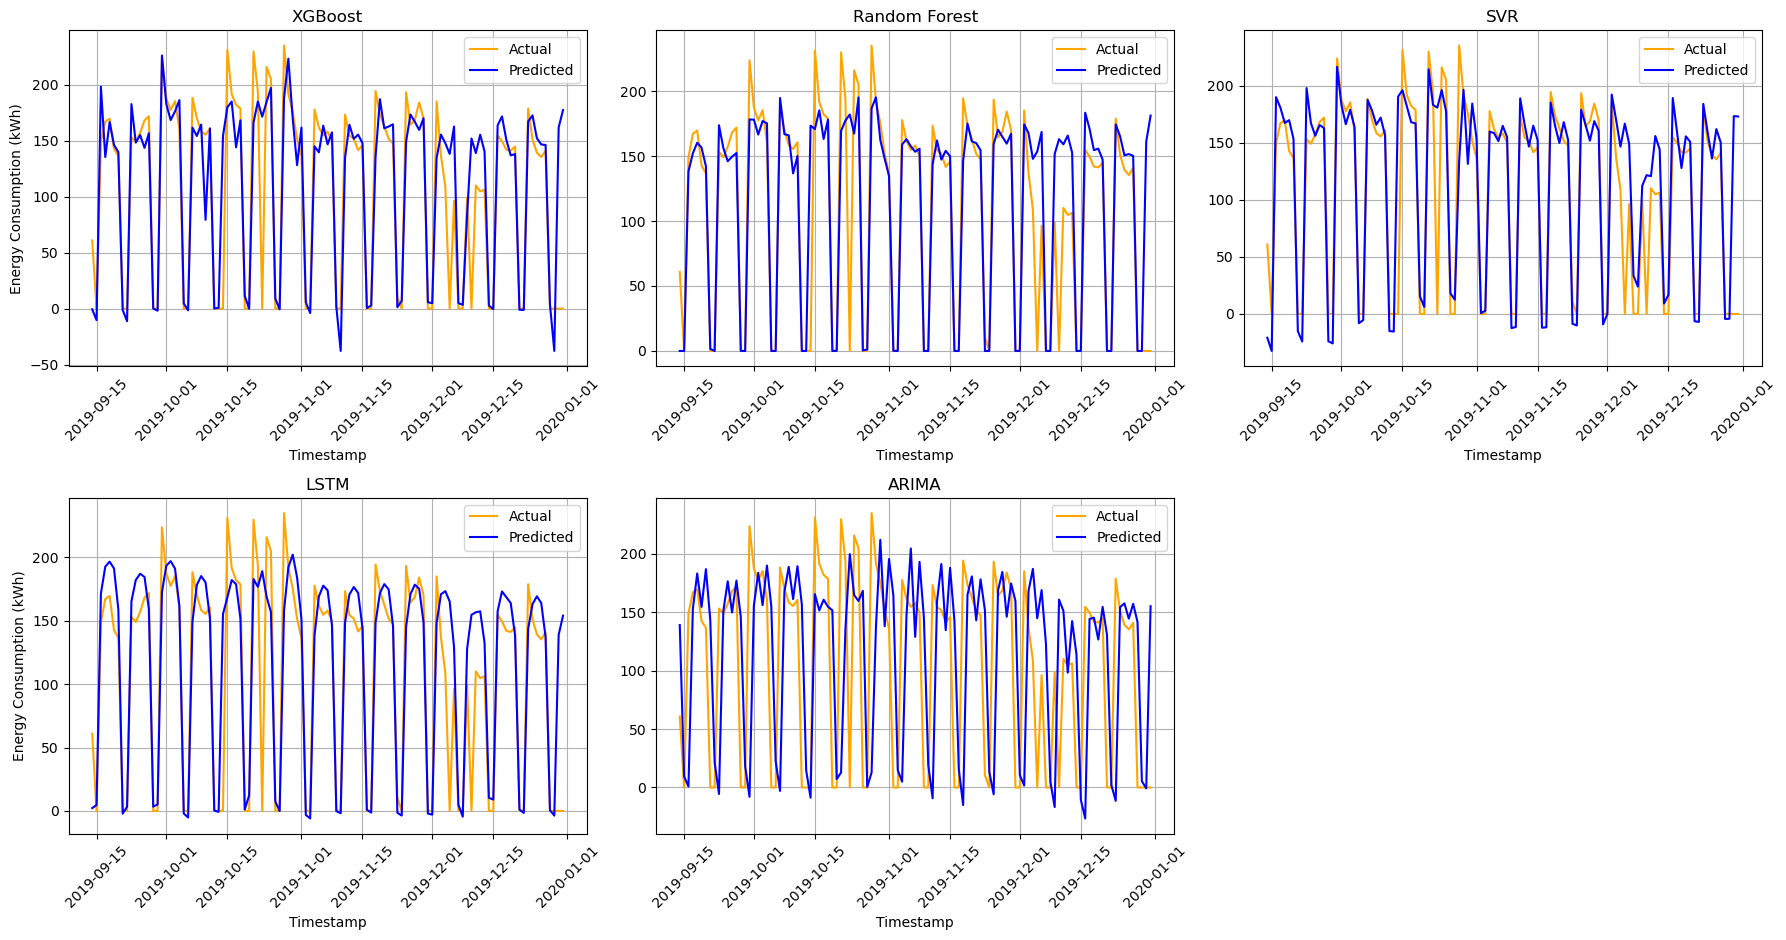

In [67]:
models = ["XGBoost", "Random Forest", "SVR", "LSTM", "ARIMA"]
y_pred_lags = [xgb_pred_tb[1], rf_pred_tb[1], svr_pred_tb[1], lstm_pred_tb[1], arima_model['pred']]
plot_comparison_lag_only(models, svr_actual[1], y_pred_lags, timestamps_test)

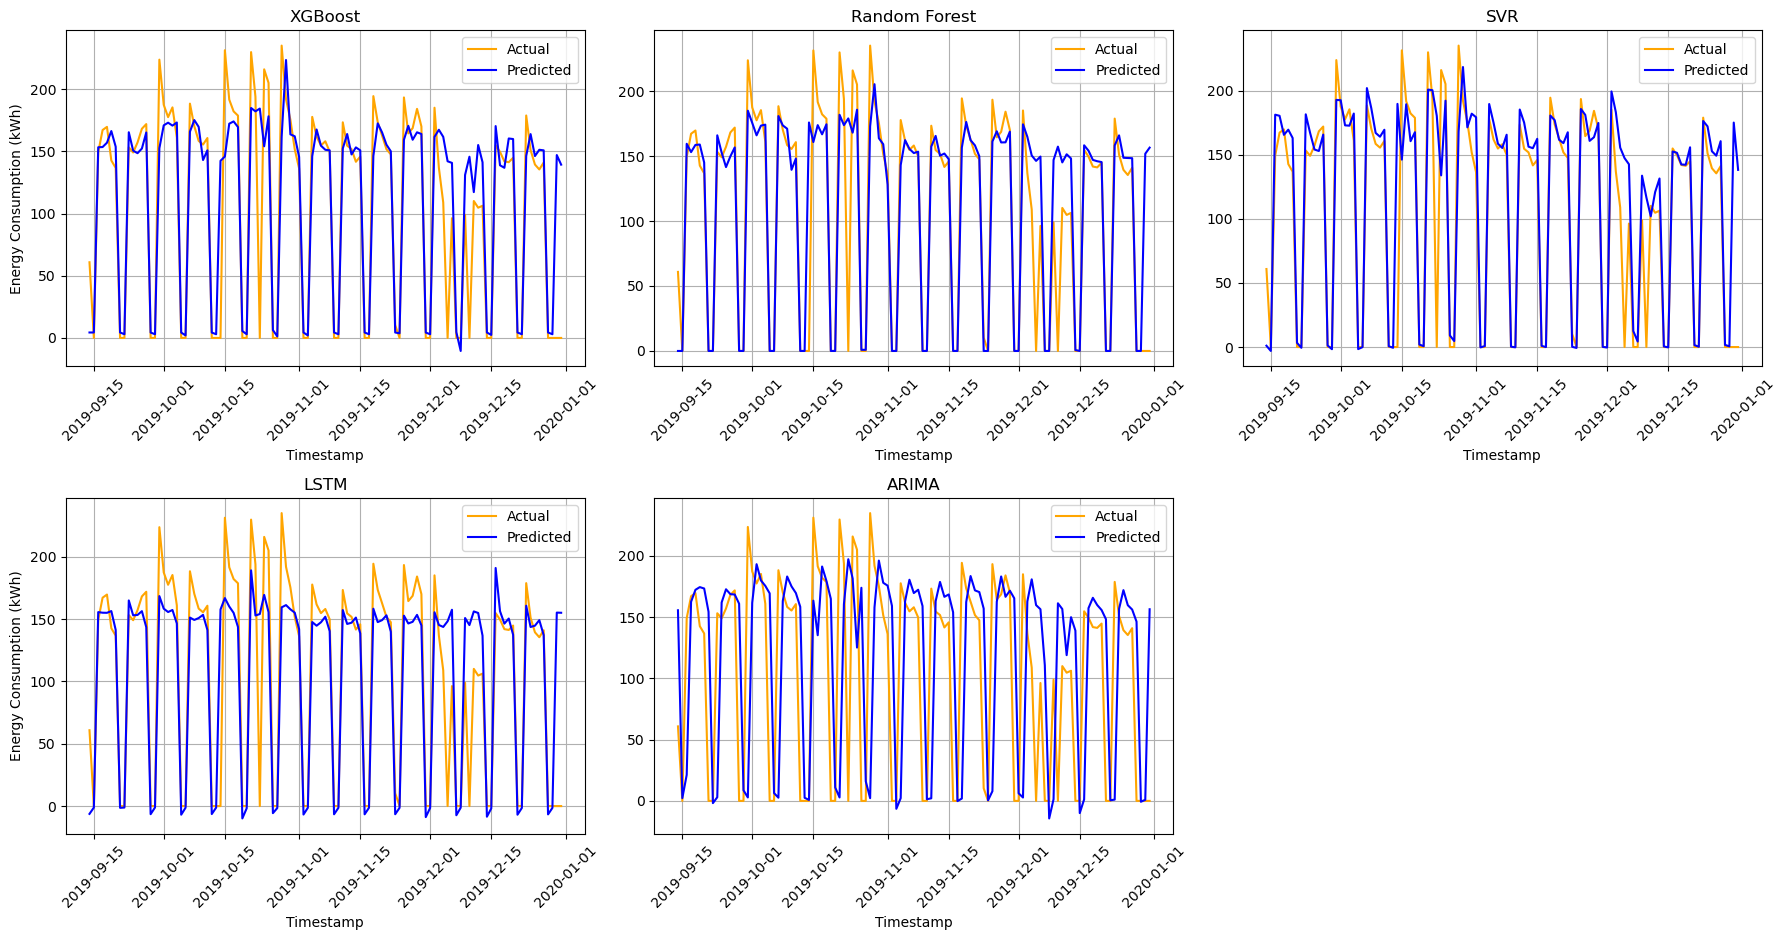

In [68]:
models = ["XGBoost", "Random Forest", "SVR", "LSTM", "ARIMA"]
y_pred_lags = [xgb_pred_ht[1], rf_pred_ht[1], svr_pred_ht[1], lstm_pred_ht[1], arima_ht['pred']]
plot_comparison_lag_only(models, svr_actual[1], y_pred_lags, timestamps_test)

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_comparison(models, 
                    y_actual, 
                    y_pred_lags, 
                    y_pred_lag_times, 
                    y_pred_tuneds, 
                    timestamps):
    """
    Parameters:
    - models: list of model names (length 5)
    - y_actual: actual values
    - y_pred_lags: list of predicted values for lag features only for each model (length 5)
    - y_pred_lag_times: list of predicted values for lag + time features for each model (length 5)
    - y_pred_tuneds: list of predicted values after hyperparameter tuning for each model (length 5)
    - timestamps: timestamp data
    """
    
    # Buat DataFrame dasar
    df_plot = pd.DataFrame({
        "timestamp": pd.to_datetime(timestamps),
        "actual": y_actual
    })
    
    # Tambahkan prediksi untuk setiap model dan jenis fitur
    for i, model in enumerate(models):
        df_plot[f"pred_lag_{model}"] = y_pred_lags[i]
        df_plot[f"pred_lag_time_{model}"] = y_pred_lag_times[i]
        df_plot[f"pred_tuned_{model}"] = y_pred_tuneds[i]
    
    df_plot.set_index("timestamp", inplace=True)
    
    # Buat figure dengan layout 5x3 (5 baris untuk model, 3 kolom untuk jenis fitur)
    fig, axs = plt.subplots(5, 3, figsize=(18, 25), sharey=True)
    
    # Plot untuk setiap model dan jenis fitur
    for i, model in enumerate(models):
        # Kolom 1: Lag Features Only
        axs[i, 0].plot(df_plot.index, df_plot["actual"], label="Actual", color="orange")
        axs[i, 0].plot(df_plot.index, df_plot[f"pred_lag_{model}"], label="Predicted", color="blue")
        axs[i, 0].set_title(f"{model} - Lag Features Only")
        axs[i, 0].set_xlabel("Timestamp")
        axs[i, 0].set_ylabel("Energy Consumption (kWh)")  # Label y di setiap baris
        axs[i, 0].tick_params(axis='x', rotation=45)
        axs[i, 0].grid(True)
        axs[i, 0].legend()

        # Kolom 2: Lag + Time Features
        axs[i, 1].plot(df_plot.index, df_plot["actual"], label="Actual", color="orange")
        axs[i, 1].plot(df_plot.index, df_plot[f"pred_lag_time_{model}"], label="Predicted", color="blue")
        axs[i, 1].set_title(f"{model} - Lag + Time Features")
        axs[i, 1].set_xlabel("Timestamp")
        axs[i, 1].set_ylabel("")  # Tidak ada label y di kolom tengah
        axs[i, 1].tick_params(axis='x', rotation=45)
        axs[i, 1].grid(True)
        axs[i, 1].legend()

        # Kolom 3: After Hyperparameter Tuning
        axs[i, 2].plot(df_plot.index, df_plot["actual"], label="Actual", color="orange")
        axs[i, 2].plot(df_plot.index, df_plot[f"pred_tuned_{model}"], label="Predicted", color="blue")
        axs[i, 2].set_title(f"{model} - After Hyperparameter Tuning")
        axs[i, 2].set_xlabel("Timestamp")
        axs[i, 2].set_ylabel("")  # Tidak ada label y di kolom kanan
        axs[i, 2].tick_params(axis='x', rotation=45)
        axs[i, 2].grid(True)
        axs[i, 2].legend()
    
    # Judul utama
    fig.suptitle("Comparison of Models and Feature Types", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

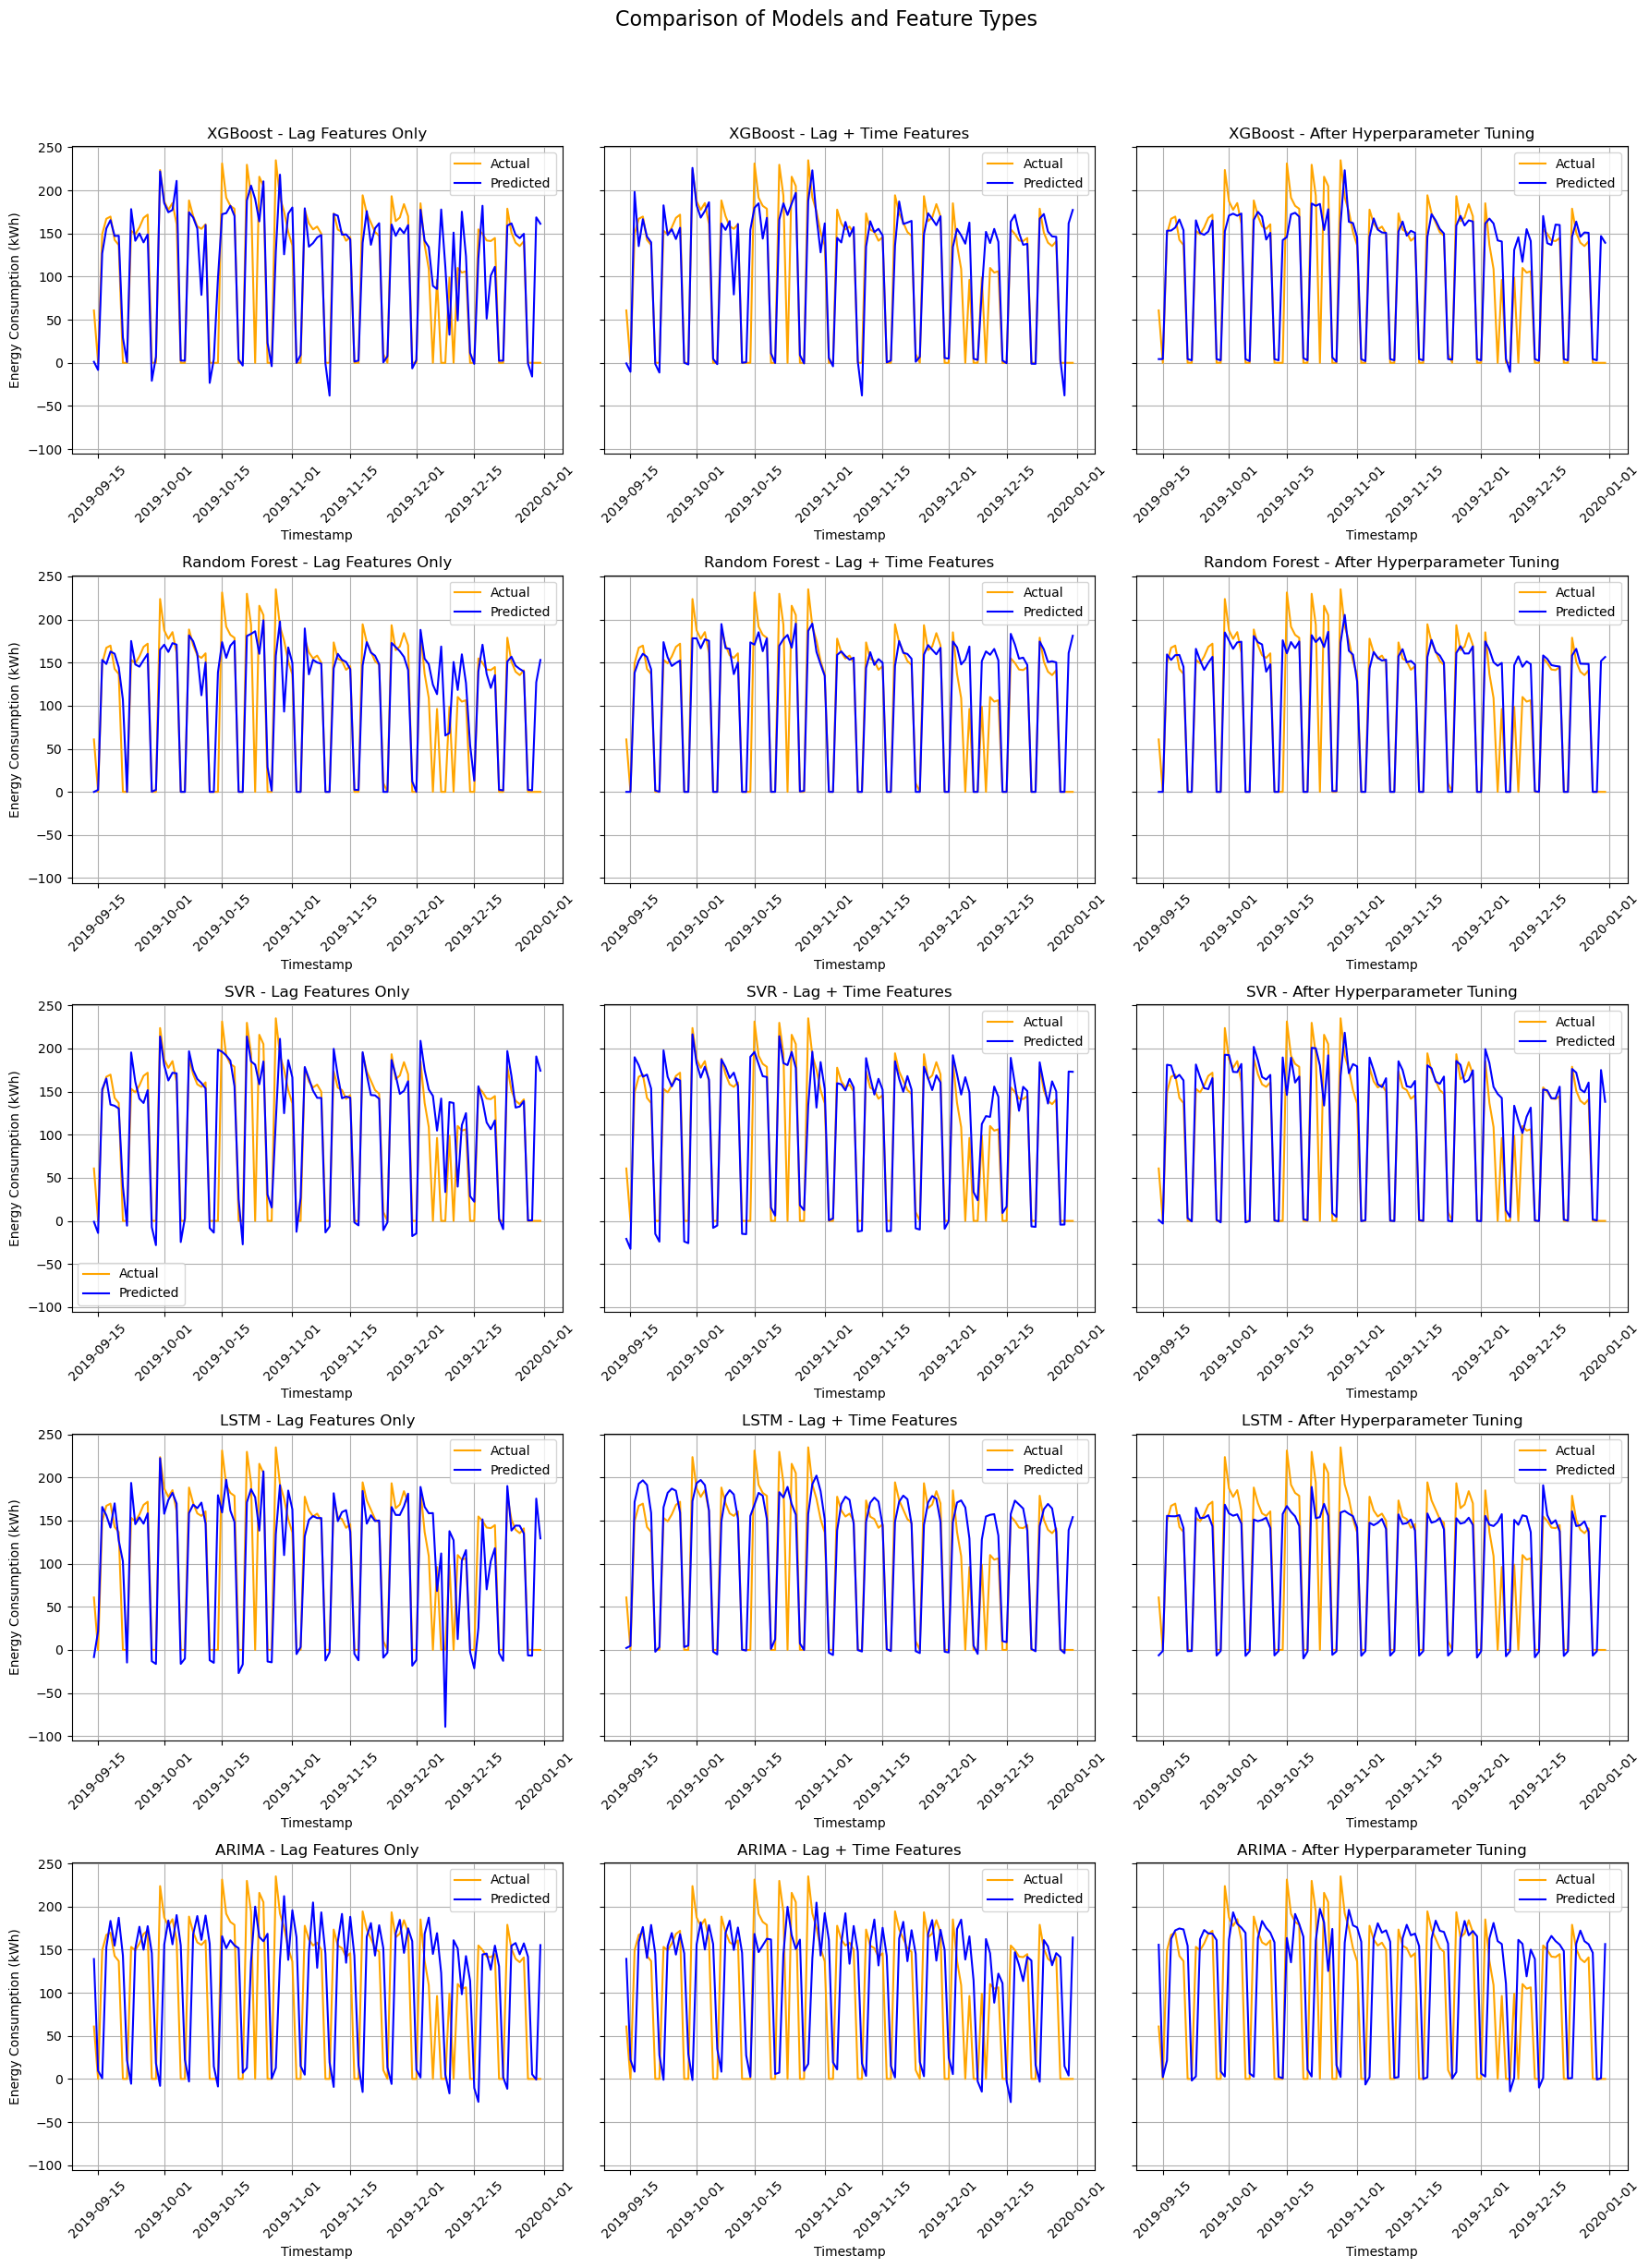

In [75]:
models = ["XGBoost", "Random Forest", "SVR", "LSTM", "ARIMA"]
y_pred_lags = [xgb_pred[1], rf_pred[1], svr_pred[1], lstm_pred[1], arima_model['pred']]
y_pred_lag_times = [xgb_pred_tb[1], rf_pred_tb[1], svr_pred_tb[1], lstm_pred_tb[1], sarima_model['pred']]
y_pred_tuneds = [xgb_pred_ht[1], rf_pred_ht[1], svr_pred_ht[1], lstm_pred_ht[1], arima_ht['pred']]
plot_comparison(models, svr_actual[1], y_pred_lags, y_pred_lag_times, y_pred_tuneds, timestamps_test)